# Thermal slabs with a visco-elastic-plastic core



Load python functions needed for underworld. Some additional python functions from os, math and numpy used later on.

In [1]:
#!pip install natsort
#!pip install networkx

In [2]:
import networkx as nx
import underworld as uw
import math
from underworld import function as fn
import glucifer
#import matplotlib.pyplot as pyplot
import time
import numpy as np
import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import slippy2 as sp



from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [3]:
def mpy_to_kmpma(mpy):
    """
    convert meters per year to kilometers per year
    Args:
        mpy (float): velocity in meters per year
    Returns:
        velocity in kilometers per year
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    return 1e3*mpy

def myts(mys):
    """
    convert millions of years to seconds
    Args:
        mys (float): millions or years
    Returns:
        seconds
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    secs = mys*(3600.*24*365)*1e6
    return secs

def stmy(secs):
    """
    convert millions of years to seconds
    Args:
        mys (float): millions or years
    Returns:
        seconds
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    myr = secs/((3600.*24*365)*1e6)
    return myr

In [4]:
#Display working directory info if in nb mode
if (len(sys.argv) > 1):
    if (sys.argv[1] == '-f'):
        !pwd && ls

/Users/dansandiford/Documents/programming/earthsci_code/python/vep
1_05_StokesSinker.ipynb base_model.ipynb        test.gldb
README.md               base_model.py
adv-diff-slab.ipynb     results


In [5]:
############
#Model name.  
############
Model = "T"
ModNum = 0

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])


In [6]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so not procs run the check in the next cell too early 

In [7]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False
        

        

results/T/0/Base/checkpoint/ is empty


Set physical constants and parameters, including the Rayleigh number (*RA*). 

In [8]:
(1600)/128.

12.5

In [9]:
###########
#Physical parameters
###########

#The Slippy rheology class will contain dimensional and nondimensional values, linked in a self-consistent way by scaling paramters
#lowermantle.nondimensional['cohesion']
#Where lowermantle is a material class (generated within a rheology class); and non dimensional is a dictionary

#UW naming conventions: 
#module_name, package_name, ClassName, function_name, method_name, 
#ExceptionName, propertyName GLOBAL_CONSTANT_NAME, globalVarName, instanceVarName, functionParameterName, localVarName
###########


#dimensional parameter dictionary
dp = edict({'LS':2890.*1e3,
           'rho':3300,
           'g':9.81, 
           'eta0':1e23,
           'k':10**-6,
           'a':1.25*10**-5, 
           'TS':273.,
           'TB':2773.,
           'deltaT':2500, 
           'cohesion':1e7, 
           'E':240000., 
           'R':8.314,
           'V':6.34*(10**-7),
           'StALS': 27.*1e3})

#non-dimensional parameter dictionary
#One draw back of a dictionary structure, is that variables cannot link to other variables
RAfac = 20.
Stressfac =(RAfac**(2/3.))
ndp = edict({'RA':1e6*RAfac,      
              'LS':1.,
              'eta0':1.,
              'StAeta0':0.1,
              'k':1.,
              'E':11.55,
              'V':3.0,
              'H':20.,
              'TR':(1600./2500.),
              'TS':(dp.TS/2500.),
              'RD':1.,
              'cohesion':1577.*RAfac,
              'cohesion_reduce':10.,
              'fc':0.1, 
              'low_visc':1e-4,
              'up_visc':1e5,
              'random_temp': 0.05})


#A few parameters defining lengths scales, affects materal transistions etc.
MANTLETOCRUST = (27.*1e3)/dp.LS #Crust depth
CRUSTTOMANTLE = (300.*1e3)/dp.LS 
LITHTOMANTLE = (660.*1e3)/dp.LS 
MANTLETOLITH = (200.*1e3)/dp.LS 
TOPOHEIGHT = (0.*1e3)/dp.LS  #rock-air topography limits
CRUSTTOECL  = (100.*1e3)/dp.LS
AVGTEMP = 0.53 #Used to define lithosphere


#Switch on additinal physical mechanisms like crust buoyancy, eclogite buoyancy, lower mantle viscosity, melt viscosity reduction 

crust_buoyancy = False
ecl_buoyancy = False
lower_mantle = True
melt_viscosity_reduction= True


#Compositional Rayliegh numbers for air, crust, ecglogite
ETAREF = dp.rho*dp.g*dp.a*dp.deltaT*((dp.LS)**3)/(ndp.RA*dp.k) #equivalent dimensional reference viscosity
#RC = (3300.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
RCA = (1650.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
COMP_RA_FACT_AIR = RCA/ndp.RA
RCC = (100.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for crust
COMP_RA_FACT_CRUST = RCC/ndp.RA
RCE = -1*(100.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for eclogite 
COMP_RA_FACT_ECL = RCE/ndp.RA
ndp["StA_RA"] = ndp.RA*COMP_RA_FACT_AIR
if crust_buoyancy:
    ndp["Crust_RA"] = ndp.RA*COMP_RA_FACT_CRUST
else:
    ndp["Crust_RA"] = 0.
if ecl_buoyancy:
    ndp["Ecl_RA"] = ndp.RA*COMP_RA_FACT_ECL
else:
    ndp["Ecl_RA"] = 0.
    


#######################To be replaced soon
#Physical parameters that can be defined with STDIN,
#The == '-f': check is a a hack check to see cover the notebook case
if len(sys.argv) == 1:
    ndp.cohesion = ndp.cohesion
elif sys.argv[1] == '-f':
    ndp.cohesion = ndp.cohesion
else:
    ndp.cohesion = float(sys.argv[1])*newvisc

In [10]:
###########
#Boundary layer / slab paramaters
###########
velmy = 0.02 #m/y
vel = mpy_to_kmpma(velmy) #km/my
off = -0.0 #dimensionless offset

#Slab perturbation paramaters
Roc = 450.
Crust = 35.
theta = 89.


In [11]:
ndp.cohesion

31540.0

In [12]:
###########
#Model setup parameters
###########

stickyAir = False

MINX = -1.
MINY = 0.
MAXX = 1.0

#MAXY = 1.035
MAXY = 1.

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    
dim = 2          # number of spatial dimensions


#MESH STUFF

RES = 96


if MINX == 0.:
    Xres = RES
else:
    Xres = 2*RES

if stickyAir:
    Yres = RES
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = RES
    MAXY = 1.


periodic = [False, False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"

refineMesh = True


#System/Solver stuff

PIC_integration=True
ppc = 25

In [13]:
###########
#Model Runtime parameters
###########

swarm_update = 10
swarm_repop = 25
files_output = 1e6
gldbs_output = 25
images_output = 1e6
checkpoint_every = 25
metric_output = 25
sticky_air_temp = 10

comm.Barrier() #Barrier here so not procs run the check in the next cell too early 

assert metric_output <= checkpoint_every, 'Checkpointing should run less or as ofen as metric output'
#assert (metric_output >= swarm_update), 'Swarm update is needed before checkpointing'
#assert metric_output >= sticky_air_temp, 'Sticky air temp should be updated more frequently that metrics'


In [14]:
###########
#Model output parameters
###########

#Do you want to write hdf5 files - Temp, RMS, viscosity, stress?
writeFiles = True
loadTemp = True

    

In [15]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = elementType,
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX,MINY), 
                                 maxCoord=(MAXX,MAXY), periodic=periodic)



velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [16]:
Xres, MINX, periodic, elementType

(192, -1.0, [False, False], 'Q1/dQ0')

Create Finite Element (FE) variables for the velocity, pressure and temperature fields. The last two of these are scalar fields needing only one value at each mesh point, while the velocity field contains a vector of *dim* dimensions at each mesh point.

Create some dummy fevariables for doing top and bottom boundary calculations.

## Refine mesh

In [17]:
#X-Axis

if refineMesh:
    mesh.reset()
    axis = 0
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (abs(mesh.maxCoord[axis]) - abs(mesh.minCoord[axis]))/2.
    el_reduction = 0.5001
    dx = mesh.maxCoord[axis] - min_point

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction) *deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    sp.deform_1d(deform_lengths, mesh,axis = 'x',norm = 'Min', constraints = [])

In [18]:
axis = 1
orgs = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)

value_to_constrain = 1.


yconst = [(sp.find_closest(orgs, value_to_constrain), np.array([1.,0]))]


In [19]:
#Y-Axis
if refineMesh:
    #Y-Axis
    axis = 1
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (mesh.maxCoord[axis])
    el_reduction = 0.5001
    dx = mesh.maxCoord[axis]

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction)*deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    sp.deform_1d(deform_lengths, mesh,axis = 'y',norm = 'Min', constraints = [])

# ICs and BCs

In [63]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
temperatureDotField.data[:] = 0.


## Temp ICs

In [21]:
#Age function:
def agefunc(x, szloc, vel = 100., dom = (-1.,1.), D = 2890.):
    """
    Create a (linear) age function based on ridges being the sides of the model,
    and subduction zone location at the dimesnionaless (model) position "szloc"
    Args:
        x (float): dimenisionless value to get age (horizontal coordinate)
        szloc (float): dimensionless (model) horizntal extent
        vel(float): in km/my
        dom (tuple): domain boundary
        D (float): dimensional domain depth
        
    Returns:
        the age in millions of years
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    if x >= szloc:
        #distance from ridge in km
        dx = (dom[1] - x) * D
        age = (dx)/vel
    else:
        dx = abs(dom[0] - x) * D
        age = (dx)/vel
    return age 


def tempfunc(age, kappa, depth,  t0=0.64):
    """
    return dimensionless halfspace cooling model fucntion,
    Args:
        age (float): millions or years
        kappa (float): diffusivity, m**2/s
        depth (float): kilometers
        t0 (float): the initial temperature of the halfspace
    Returns:
        dimensionless temp (0. - 1.)
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    #1000 in line below to convert back to km
    secs = myts(age)
    temp = t0*math.erf((depth)/(2*math.sqrt(secs*kappa)/1000))
    return temp
                       
def lithdepthfunc(age, kappa):
    """
    returns depth or thermal lithosphere in kilometers
    Args:
        age (float): millions or years
        kappa (float): diffusivity, m**2/s
    Returns:
        depth kilometers
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    depth_metres = 2.32*math.sqrt(myts(age)*kappa)
    return depth_metres/1000.

In [22]:
#agefunc(0.2, off, vel = vel, dom = (MINX,MAXX))

In [23]:
#Make the thermal boundary layer
#Including a fudge that can reduce the depth of the thermal lithosphere
fudge = 1.

for index, coord in enumerate(mesh.data):
    xloc = coord[0]
    agema = agefunc(xloc, off, vel = vel, dom = (MINX,MAXX))
    #print(agema)
    if xloc < off: #This bit gets rid of overiding plate
        temperatureField.data[index] = 0.8
    elif (1.-coord[1]) < (lithdepthfunc(agema, dp.k)*1e3/dp.LS)*fudge: #comparison of dimensionless (model) lengths
        zlockm = ((1.- coord[1])* dp.LS)/1e3 # dimensional depth kms
        t = tempfunc(agema, dp.k, zlockm,  t0=0.8)
        temperatureField.data[index] = t        
    else:
        temperatureField.data[index] = 0.8

In [24]:
(lithdepthfunc(200., dp.k)*1e3)/dp.LS

0.06375414758206731

In [25]:
(lithdepthfunc(agema, dp.k)*1e3/dp.LS)

0.0

## Slab perturbation

In [71]:
testField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
testField.data[:] = 0.

In [80]:
if not checkpointLoad:

    def inCircleFnGenerator(centre, radius):
        coord = fn.input()
        offsetFn = coord - centre
        return fn.math.dot( offsetFn, offsetFn ) < radius**2

    #Setup slab perturbation params (mostly dimensionles / model params here)
    phi = 90. - theta
    RocM = (Roc/dp.LS)*1e3
    CrustM = MANTLETOCRUST
    slabdepth = lithdepthfunc(agefunc(off, off, vel), dp.k)
    slabdepthM = (lithdepthfunc(agefunc(off, off, vel), dp.k)/dp.LS)*1e3
    Org = (0.+off, 1.-RocM)
    #Use three circles to define our slab and crust perturbation,  
    Oc = inCircleFnGenerator(Org , RocM)
    Oc2 = inCircleFnGenerator(Org , RocM + (20e3/dp.LS)) #a slightly larger circle helps smother the interpolation
    Ic = inCircleFnGenerator(Org , RocM - slabdepthM)
    Cc = inCircleFnGenerator(Org , RocM - CrustM)
    dx = (RocM)/(np.math.tan((np.math.pi/180.)*phi))

    #We'll also create a triangle which will truncate the circles defining the slab...
    if off > 1: 
        ptx = off + dx
    else:
        ptx = off - dx

    coords = ((0.+off, 1), (0.+off, 1.-RocM), (ptx, 1.))
    Tri = fn.shape.Polygon(np.array(coords))

    #Assign temperatures in the perturbation region
    for index, coord in enumerate(mesh.data):
        if Cc.evaluate(tuple(coord)) and Tri.evaluate(tuple(coord)) and not Ic.evaluate(tuple(coord)): #in inner circle, not in outer circle
            #print("true")
            #sd = (pt.distance(Oc.boundary)*dp.LS)/1e3
            sd = ((RocM - math.sqrt((coord[0] - Org[0])**2 + (coord[1] - Org[1])**2))*dp.LS)/1e3 #distance from slab edge in Km
            if sd < (lithdepthfunc(agefunc(off, off, vel = vel, dom = (MINX,MAXX)), dp.k))*fudge:
                t = tempfunc(agefunc(off, off, vel = vel, dom = (MINX,MAXX)), dp.k, sd, t0=0.8)
                temperatureField.data[index] = t
                testField.data[index] = 1.
            else: 
                temperatureField.data[index] = 0.8


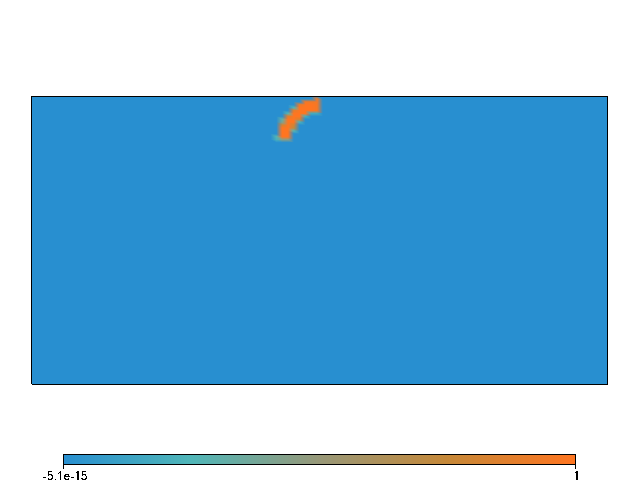

In [73]:
figStrainRate = glucifer.Figure()
figStrainRate.append( glucifer.objects.Surface(mesh, testField))
figStrainRate.show()

In [28]:
#CrustM

In [29]:
#from geopandas import GeoSeries
#%matplotlib inline
#g = GeoSeries([slabshape2.difference(slabshape)])
#g.plot()

In [30]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
# send boundary condition information to underworld
IWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
JWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
TWalls = mesh.specialSets["MaxJ_VertexSet"]
BWalls = mesh.specialSets["MinJ_VertexSet"]

In [31]:
#Set Dirichlet Temp conditions

for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = 1.
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = 0.


# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              indexSetsPerDof=(IWalls, JWalls) )

# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(JWalls,) )


#dT_dy = [0.,0.]

# also set dirichlet for temp field
#neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
#                                         indexSetsPerDof=BWalls)

In [32]:
#temperatureField.data[TWalls.data].max()

##Add Random 125 K temp perturbation


tempNump = temperatureField.data

#In gerneral we only want to do this on the initial setup, not restarts

if not checkpointLoad:
    for index, coord in enumerate(mesh.data):
        pertCoeff = (0.05*(np.random.rand(1)[0] - 0.5)) #this should create values between [-0.5,0.5] from uniform dist.
        ict = tempNump[index]
        tempNump[index] = ict + pertCoeff

In [33]:

figVelocityMag = glucifer.Figure(figsize=(1024,384))
figVelocityMag.append( glucifer.objects.Surface(mesh, temperatureField) )
figVelocityMag.show()
figVelocityMag.append(glucifer.objects.Mesh(mesh))
figVelocityMag.save_database('test.gldb')

# Particles

In [76]:
###########
#Material Swarm and variables
###########

gSwarm = uw.swarm.Swarm(mesh=mesh)
materialVariable = gSwarm.add_variable( dataType="int", count=1 )
rockIntVar = gSwarm.add_variable( dataType="double", count=1 )
airIntVar = gSwarm.add_variable( dataType="double", count=1 )
lithIntVar = gSwarm.add_variable( dataType="double", count=1 )
dummyIntVar = gSwarm.add_variable( dataType="double", count=1 ) #This one is used so we can safely ignore values in the air region

varlist = [materialVariable, rockIntVar, airIntVar, lithIntVar]
varnames = ['materialVariable', 'rockIntVar', 'airIntVar', 'lithIntVar']

In [77]:
###########
#Swarms for surface integrals when using Sticky air
###########

snum = 1000.
dx = (mesh.data[:,0].max()- mesh.data[:,0].min())/snum
yp = 0.9947 #1. - yelsize/2. at res = 96

mesh.data[:,0].max()
xps = np.linspace(mesh.data[:,0].min(),mesh.data[:,0].max(), snum)
yps = [yp for i in xps]

surfintswarm = uw.swarm.Swarm( mesh=mesh )
dumout = surfintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

yps = [ 1.- yp  for i in xps]

baseintswarm = uw.swarm.Swarm( mesh=mesh)
dumout = baseintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

#Initialise swarm variables, or Swarm checkpoint load

In [78]:
mantleIndex = 0
lithosphereIndex = 1
eclIndex = 2
crustIndex = 3
airIndex = 4




if checkpointLoad:
    checkpointLoadDir = natsort.natsorted(checkdirs)[-1]
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    # Create the layout object
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=ppc)
    # Now use it to populate.
    gSwarm.populate_using_layout( layout=layout )

    # Lets initialise the 'materialVariable' data to represent different materials
    # Set the material to heavy everywhere via the numpy array
    materialVariable.data[:] = mantleIndex
    
    
    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < 0:
                 materialVariable.data[particleID] = airIndex
        elif (1. - gSwarm.particleCoordinates.data[particleID][1]) < MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex


#Material Graphs

In [37]:
##############
#Important: This is a quick fix for a bug that arises in parallel runs
##############
material_list = [0,1,2,3,4]


In [38]:
print( "unique values after swarm has loaded:" + str(np.unique(materialVariable.data[:])))


unique values after swarm has loaded:[0 3]


In [39]:


#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#######Graph object
DG = nx.DiGraph(field="Depth")

#######Nodes
#Note that the order of materials, deepest to shallowest is important
DG.add_node(0, mat='mantle')
DG.add_node(1, mat='lithosphere')
DG.add_node(2, mat='ecl')
DG.add_node(3, mat='crust')
DG.add_node(4, mat='air')


labels=dict((n,d['mat']) for n,d in DG.nodes(data=True))
pos=nx.spring_layout(DG)


#######Edges
#anything to air
DG.add_edges_from([(0,4),(1,4), (3,4)])
DG[0][4]['depthcondition'] = -1*TOPOHEIGHT
DG[1][4]['depthcondition'] = -1*TOPOHEIGHT
DG[3][4]['depthcondition'] = -1*TOPOHEIGHT


#Anything to mantle
DG.add_edges_from([(3,0), (1,0), (2,0)])
DG[3][0]['depthcondition'] = CRUSTTOMANTLE #Normal crust
DG[1][0]['depthcondition'] = LITHTOMANTLE #This means we're going to kill lithosphere at the 660.
DG[2][0]['depthcondition'] = CRUSTTOMANTLE #Eclogite crust

#Anything to lithsphere
DG.add_edges_from([(0,1),(4,1)])
DG[0][1]['depthcondition'] = MANTLETOLITH
DG[0][1]['avgtempcondition'] = 0.75*AVGTEMP #definition of thermal lithosphere


#Anything to crust
DG.add_edges_from([(0,3), (1,3), (4,3)])
DG[0][3]['depthcondition'] = MANTLETOCRUST
DG[1][3]['depthcondition'] = MANTLETOCRUST
DG[4][3]['depthcondition'] = TOPOHEIGHT

#crust to eclogite
DG.add_edges_from([(3,2)])
DG[3][2]['depthcondition'] =CRUSTTOECL






In [40]:
CRUSTTOMANTLE

0.10380622837370242

In [41]:
#material_list

In [42]:
remove_nodes = []
for node in DG.nodes():
    if not node in material_list:
        remove_nodes.append(node)
        
for rmnode in remove_nodes:
    DG.remove_node(rmnode)

In [43]:
DG.nodes()

[0, 1, 2, 3, 4]

In [44]:
#A Dictionary to map strings in the graph (e.g. 'depthcondition') to particle data arrays

particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
particletemps = temperatureField.evaluate(gSwarm)[:,0]

conditionmap = {}

conditionmap['depthcondition'] = {}
conditionmap['depthcondition']['data'] = particledepths
conditionmap['avgtempcondition'] = {}
conditionmap['avgtempcondition']['data'] = particletemps

In [45]:
def update_swarm(graph, particleIndex):
    """
    This function takes the materials graph (networkx.DiGraph), and a particle index,
    then determines if a material update is required 
    and if so, returns the new materialindex
    Args:
        graph (networkx.DiGraph): Directed multigraph representing the transformation of material types
        particleIndex (int): the particle index as corressponding to the index in the swarm data arrays
    Returns:
        if update is required the function returns the the new material variable (int) 
        else returns None
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    ##Egde gives links to other materials, we then query the conditions to see if we should change materials
    matId = materialVariable.data[particleIndex][0]
    innerchange = False
    outerchange = False
    for edge in graph[matId]:
        if outerchange:
            break
        for cond in graph[matId][edge].keys():
            outerchange = False
            if innerchange: #found a complete transition, break inner loop
                break
            currentparticlevalue = conditionmap[cond]['data'][particleIndex]
            crossover = graph[matId][edge][cond]
            if ((matId > edge) and (currentparticlevalue > crossover)):
                innerchange = False # continue on, 
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            elif ((matId < edge) and (currentparticlevalue < crossover)):
                innerchange = False
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            else:
                #condition not met, break outer loop, go to next edge, outerchange should still be False
                break
    if type(innerchange) == int:
        return innerchange

In [82]:
#Set the crust material in the slab using shapes/function from uw.

if not checkpointLoad:
    #materialVariable.data[:] = mantleIndex
    lithtemp = 0.95*0.8
    tempswarm = temperatureField.evaluate(gSwarm)[:,0]

    #At this point, we only have to assign any materials that are defined by setup shapes,
    #the rest of the materials will be assigned using the materials graph

    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if gSwarm.particleCoordinates.data[particleID][1] > (1.0 - CrustM):
            materialVariable.data[particleID] =  crustIndex
        coord = gSwarm.particleCoordinates.data[particleID]
        if Oc.evaluate(tuple(coord)) and Tri.evaluate(tuple(coord)) and not Cc.evaluate(tuple(coord)):
            #print("True")
            materialVariable.data[particleID] =  crustIndex

In [84]:
#Cleanse the swarm of its sins
#For some Material Graphs, the graph may have to be traversed more than once

check = -1
number_updated = 1

while number_updated != 0:
    number_updated = 0
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        check = update_swarm(DG, particleID)
        if check > -1:
            number_updated += 1
            materialVariable.data[particleID] = check


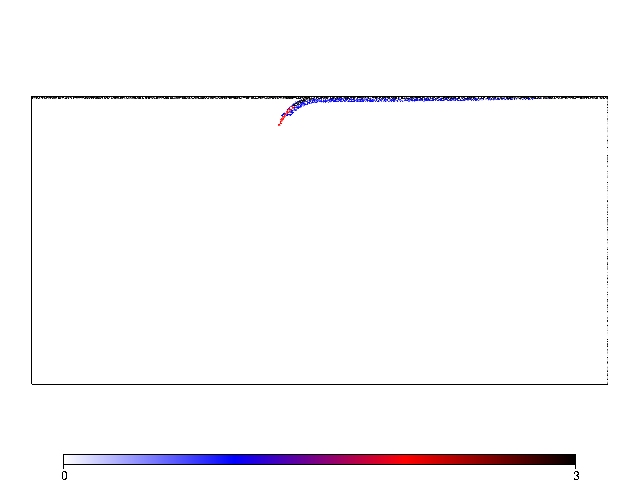

In [85]:
figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(gSwarm,materialVariable, colours='white blue red black'))
#figMat.append( glucifer.objects.Mesh(mesh))
figMat.save_database('test.gldb')
figMat.show()

##Set the values for the masking swarms

In [50]:
#Setup up a masking Swarm variable for the integrations.
#These should be rebuilt at same frequency as the metric calcualtions

rockIntVar.data[:] = 0.
notair = np.where(materialVariable.data != airIndex)
rockIntVar.data[notair] = 1.

airIntVar.data[:] = 0.
notrock = np.where(materialVariable.data == airIndex)
airIntVar.data[notrock] = 1.

lithIntVar.data[:] = 0.
islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
lithIntVar.data[islith] = 1.

dummyIntVar.data[:] = 1.
notrock = np.where(materialVariable.data == airIndex)
dummyIntVar.data[notrock] = 1e10  #We'll multiply certain swarm variables by this guy,which
#will allow us grab minimum values and assume they are from the rock part

#Material properties


In [80]:
# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))


coordinate = fn.input()
depth = 1. - coordinate[1]

#Determine yield criterion for depth (rather than pressure as given in Crameri)
#Scaling is same as van Heck and Tackley, EPSL, 2011
lithopressuregrad = dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k)

In [81]:
#ndp.TS

In [82]:
ndp.TR

0.64

In [83]:
#Linear viscosity
#arhennius = fn.misc.min(ndp.up_visc, fn.math.exp(((-1.*ndp.E) + (ndp.E / temperatureField))))
#lower_mantle = False
#melt_viscosity_reduction = False

In [84]:
fn.math.exp(0)

In [85]:
############
#Mantle
############

#Linear viscosity
eta0  = 1./np.math.exp( ndp.E / (1.+1.) )
#arhennius = eta0 * fn.math.exp( ndp.E / (temperatureField+1.) )
arhennius = fn.misc.min(ndp.up_visc, fn.math.exp(((-1.*ndp.E) + (ndp.E / (temperatureField + 1e-6)))))

lower_mantle = True
melt_viscosity_reduction = True

#implementation of the melt viscosity reduction
Tmvp = 0.5
if melt_viscosity_reduction:
    mvptest =  fn.branching.conditional( [ (temperatureField > (Tmvp + 7.5*(1. - coordinate[1])) , 0.1 ),   (         True, 1.) ] )
    arhennius = fn.misc.min(ndp.up_visc,arhennius*mvptest)


#Quick implementation of the lower mantle viscosity increase 
a = 1.
B = 30.
d0 = 800e3/dp.LS #Similar fudge to Bello et al. 
ds = d0/10.
if lower_mantle:
    print("true")
    inner1 = 1. - 0.5*(1. - fn.math.tanh(((1. - d0)-(coordinate[1]))/(ds)))
    modfac = a*fn.math.exp(np.log(B)*inner1)
    arhennius = fn.misc.min(ndp.up_visc,arhennius*modfac)
    

#Psuedo-plastic 
ys =  ndp.cohesion + (depth*ndp.fc*lithopressuregrad)
#ys =  ndp.fc*lithopressuregrad*(30e3/dp.LS) # this is the byerlee strength at 30 km
yss = fn.misc.max(ndp.cohesion, ys)
plasticvisc = yss*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
plastic = fn.misc.max(ndp.low_visc,plasticvisc)
#combine these
mantleviscosityFn = fn.misc.min(arhennius, plastic)

############
#crust
############



ysc = (ndp.cohesion/ndp.cohesion_reduce) + (depth*(ndp.fc/100.)*lithopressuregrad)
#ysc = ys/100.
ycs = fn.misc.max((ndp.cohesion/ndp.cohesion_reduce), ysc)
crustplasticvisc = ycs*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
crustplastic = fn.misc.max(ndp.low_visc,crustplasticvisc) 
crustviscosityFn = fn.misc.min(arhennius, crustplastic)

true


In [86]:
#d0

In [87]:
mantleviscosityFn.evaluate(mesh).max()

100000.0


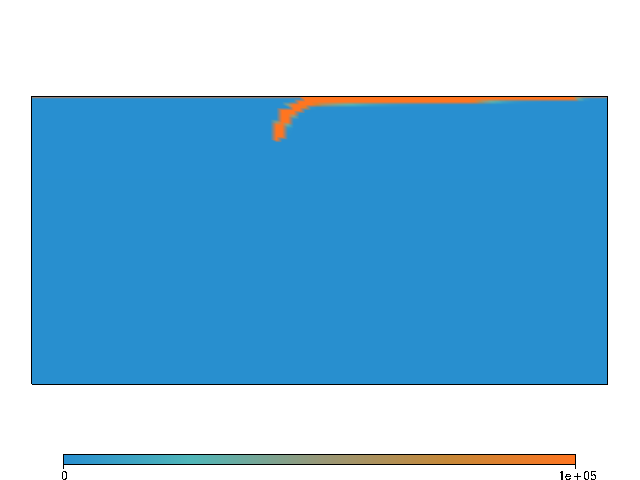

In [88]:
figStrainRate = glucifer.Figure()
figStrainRate.append( glucifer.objects.Surface(mesh, mantleviscosityFn))
figStrainRate.show()

Set up simulation parameters and functions
====

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

In [89]:
# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StAeta0, 
                                    lithosphereIndex:mantleviscosityFn, 
                                    crustIndex:crustviscosityFn,
                                    mantleIndex:mantleviscosityFn, 
                                    eclIndex:crustviscosityFn} )

densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StA_RA, 
                                    lithosphereIndex:ndp.RA*temperatureField, 
                                    crustIndex:ndp.RA*temperatureField, 
                                    mantleIndex:ndp.RA*temperatureField, 
                                    eclIndex:ndp.RA*temperatureField} )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )

buoyancyFn = gravity*densityMapFn

In [90]:
ndp.RA

20000000.0

Build the Stokes system, solvers, advection-diffusion
------

Setup linear Stokes system to get the initial velocity.

In [91]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               #swarm         = gSwarm, 
                               conditions    = [freeslipBC,],
                               fn_viscosity   = arhennius, 
                               fn_bodyforce   = buoyancyFn,
                               swarm=gSwarm)


We do one solve with linear viscosity to get the initial strain rate invariant. This solve step also calculates a 'guess' of the the velocity field based on the linear system, which is used later in the non-linear solver.

In [92]:
#We do one solve with linear viscosity to get the initial strain rate invariant. 
#This solve step also calculates a 'guess' of the the velocity field based on the linear system, 
#which is used later in the non-linear solver.

solver = uw.systems.Solver(stokesPIC)
# If not doing a restart, do a solve on the non-plastic system
if not checkpointLoad:
    solver.solve()

In [93]:
#Switch particle escape on, this will also trigger the inflow population control 
gSwarm.particleEscape = True

In [ ]:
####################
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = viscosityMapFn
###################

#Set more advanced solver option
#solver.options.main.Q22_pc_type='gkgdiag'
#solver.options.A11.ksp_rtol=1e-2
#solver.options.scr.ksp_rtol=1e-3
#solver.options.A11.ksp_type="cg"
solver.options.scr.use_previous_guess = True
#solver.options.scr.ksp_set_min_it_converge = 1
#solver.options.main.penalty=10.0

#solver.options.mg.levels = 3
#solver.options.main.remove_constant_pressure_null_space=True
#solver.options.main.penalty = 1e2

#solver.options.A11.ksp_rtol=1e-4
#solver.options.scr.ksp_rtol=1e-4

solver.options.A11.ksp_monitor=''
solver.options.A11.ksp_converged_reason=''

In [ ]:
solver.solve(nonLinearIterate=True)

In [ ]:
viscField = uw.mesh.MeshVariable( mesh=mesh,   nodeDofCount=1)
viscdata = mantleviscosityFn.evaluate(mesh)
#viscField.data[:] = viscdata


#viscVariable = gSwarm.add_variable( dataType="float", count=1 )
#viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)

solver = uw.systems.Solver(stokesPIC2) # altered from PIC2



#Set more advanced solver option
solver.options.main.Q22_pc_type='uw'
solver.options.A11.ksp_rtol=1e-5
solver.options.scr.ksp_rtol=1e-5
#solver.options.A11.ksp_type="cg"
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 1

solver.options.mg.levels = 3

#solver.options.A11.ksp_monitor=''
#solver.options.A11.ksp_converged_reason='

Solve for initial pressure and velocity using a quick non-linear Picard iteration


Create an advective-diffusive system
=====

Setup the system in underworld by flagging the temperature and velocity field variables.

In [ ]:
#uw.systems.AdvectionDiffusion?

In [168]:
#Create advdiff system



#advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
#                                         phiDotField    = temperatureDotField, 
#                                         velocityField  = velocityField, 
#                                         fn_diffusivity = 1.0,
#                                         fn_sourceTerm = 0.,
#                                         conditions     = [tempBC,] )


advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 20.0,
                                         fn_diffusivity = 1.0, 
                                         conditions     = [dirichTempBC,] )



advector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

Metrics for benchmark
=====

Define functions to be used in the time loop. For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temp... $$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers... $$N = \int^1_0 \frac{\partial T}{\partial y} \rvert_{y=0/1} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
* max and min viscosity over the whole domain
* average rate of work done against gravity...$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation...$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

In [169]:
#Setup some Integrals. We want these outside the main loop...
tempVariable = gSwarm.add_variable( dataType="double", count=1 )
tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
tempint = uw.utils.Integral((tempVariable*rockIntVar), mesh)


areaint = uw.utils.Integral((1.*rockIntVar),mesh)
lithareaint = uw.utils.Integral((1.*lithIntVar),mesh)

v2int = uw.utils.Integral(fn.math.dot(velocityField,velocityField)*rockIntVar, mesh)


dwint = uw.utils.Integral(temperatureField*velocityField[1]*rockIntVar, mesh)


sinner = fn.math.dot(strainRate_2ndInvariant,strainRate_2ndInvariant)
vdint = uw.utils.Integral((4.*viscosityMapFn*sinner)*rockIntVar, mesh)
vdintair = uw.utils.Integral((4.*viscosityMapFn*sinner)*airIntVar, mesh)
vdintlith = uw.utils.Integral((4.*viscosityMapFn*sinner)*lithIntVar, mesh)


fn_stress = 2.*viscosityMapFn*uw.function.tensor.symmetric(velocityField.fn_gradient)
rockstress = fn.tensor.second_invariant(fn_stress)*rockIntVar
lithstress = fn.tensor.second_invariant(fn_stress)*lithIntVar

stresslithint = uw.utils.Integral(lithstress, mesh)


In [170]:
#These should differ if the the map function assigns different properties to bulk mantle

print(uw.utils.Integral((4.*mantleviscosityFn*sinner)*rockIntVar, mesh).evaluate()[0])
print(uw.utils.Integral((4.*viscosityMapFn*sinner)*rockIntVar, mesh).evaluate()[0])


print(uw.utils.Integral((4.*mantleviscosityFn*sinner)*airIntVar, mesh).evaluate()[0])
print(uw.utils.Integral((4.*viscosityMapFn*sinner)*airIntVar, mesh).evaluate()[0])

print(uw.utils.Integral((4.*mantleviscosityFn*sinner)*lithIntVar, mesh).evaluate()[0])
print(uw.utils.Integral((4.*viscosityMapFn*sinner)*lithIntVar, mesh).evaluate()[0])

150373.001104
149063.360301
141.462513173
0.000351875327943
2741.60928693
2222.24306161


\begin{equation}  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy \end{equation}

In [171]:
def avg_temp():
    return tempint.evaluate()[0]/areaint.evaluate()[0]

#This one gets cleaned up when Surface integrals are available
def nusselt(tempfield, swarm, dx):
    #Update the swarm variable
    tempgrad = tempfield.fn_gradient
    valcheck = tempgrad[1].evaluate(swarm)
    if valcheck is None:
        vals = np.array(0, dtype='float64')
    else:
        vals = valcheck.sum()*dx
    return vals

def rms():
    return math.sqrt(v2int.evaluate()[0]/areaint.evaluate()[0])

#This one gets cleaned up when Surface integrals are available
def rms_surf(swarm, dx):
    rmsmaxfn = fn.math.dot(velocityField,velocityField)
    rmscheck = rmsmaxfn.evaluate(swarm)
    if rmscheck is None:
        #print "watch out"
        rmsvals = np.array(0, dtype='float64')
    else:
        rmsvals = np.sqrt(rmscheck.sum()*dx)
        #print "okay"
    return rmsvals

def max_vx_surf(velfield, swarm):
    check = velfield[0].evaluate(swarm)
    if check is None:
        return 0.
    else:
        return check.max()


#def max_vy_surf(velfield, swarm):
#    surfvelxmaxfn = fn.view.min_max(velfield[1])
#    surfvelxmaxfn.evaluate(swarm)
#    return surfvelxmaxfn.max_global()

def gravwork(workfn):
    return workfn.evaluate()[0]

def viscdis(vdissfn):
    return vdissfn.evaluate()[0]

def visc_extr(viscfn):
    vuviscfnMax = fn.view.min_max(viscfn)
    vuviscfnMax.evaluate(gSwarm)
    vuviscfnMin = fn.view.min_max(viscfn*dummyIntVar)
    vuviscfnMin.evaluate(gSwarm)
    return vuviscfnMax.max_global(), vuviscfnMin.min_global()


def stress_max(scalarStressfn):
    fn_minmax_stress = fn.view.min_max(scalarStressfn)
    ignore_stress = fn_minmax_stress.evaluate(gSwarm)
    return fn_minmax_stress.max_global()


def avg_lith_stress():
    return stresslithint.evaluate()[0]/lithareaint.evaluate()[0]

In [172]:
lithareaint.evaluate()[0]

0.04164070368487442

In [173]:
#Check dem 
#stress_max(rockstress)
#visc_extr(viscosityMapFn), ndp.StAeta0
#avg_lith_stress()

In [174]:
#Fields for saving data / fields

rmsField = uw.mesh.MeshVariable( mesh=mesh,   nodeDofCount=1)
rmsfn = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
rmsdata = rmsfn.evaluate(mesh)
rmsField.data[:] = rmsdata 

viscField = uw.mesh.MeshVariable( mesh=mesh,   nodeDofCount=1)
viscdata = mantleviscosityFn.evaluate(mesh)
viscField.data[:] = viscdata


strainrateField = uw.mesh.MeshVariable( mesh=mesh,   nodeDofCount=1)
srtdata = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.fn_gradient ))
rostfield = srtdata.evaluate(mesh)
strainrateField.data[:] = rostfield

viscVariable = gSwarm.add_variable( dataType="float", count=1 )
viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)


In [175]:
#Images
figEta = glucifer.Figure()
figEta.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True))


figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
figMat.append( glucifer.objects.Mesh(mesh))


figStrainRate = glucifer.Figure()
figStrainRate.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True))


figVelocityMag = glucifer.Figure()
figVelocityMag.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField))
)
figTemp = glucifer.Figure()
figTemp.append( glucifer.objects.Surface(mesh, temperatureField))



#Pack some stuff into a database as well
figDb = glucifer.Figure()
figDb.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
figDb.append( glucifer.objects.Mesh(mesh))
figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, arrowHead=0.2, scaling=0.01))
figDb.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Surface(mesh, temperatureField))
                           

In [176]:

pics = uw.swarm.PICIntegrationSwarm(gSwarm)

In [177]:
varnames

['materialVariable', 'rockIntVar', 'airIntVar', 'lithIntVar']

In [172]:
def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        f_o.write((16*'%-16s ' + '\n') % (realtime, Viscdis, float(Nu0glob), float(Nu1glob), Avg_temp, 
                                              Rms,Rmsurfglob,Max_vx_surfglob,Gravwork, etamax, etamin, 
                                              Viscdisair, Viscdislith,Avg_stress, Max_stress_rock, Max_stress_lith))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [materialVariable], varnames = ['materialVariable']):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"))
        
    

In [173]:
###########
#Open file for writing metrics
###########

if checkpointLoad:
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    #os.rename(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    realtime = prevdata[prevdata.shape[0]-1, 0]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

Main simulation loop
=======

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.


In [ ]:
# initialise timer for computation
startMain = time.clock()
# Perform steps#
while realtime < 0.2:
#while step < 25:
    #Enter non-linear loop
    print step
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    #start = time.clock()
    advDiff.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advDiff time is: " + str(machine_time))
    # Advect swarm using this timestep size
    #start = time.clock()
    advector.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advector time is: " + str(machine_time))
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    
    ################
    #Update temperature field in the air region
    ################
    if (step % sticky_air_temp == 0):
        for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = 0.
 
    ################
    #Particle update
    ###############
    #if (step % swarm_update == 0) or (step % metric_output == 0): #These updates should be done before any metric output
    if (step % swarm_update == 0): #These updates should be done before any metric output
        #These swarm variables get updated first, as they are used to determine material changes
        particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
        particletemps = temperatureField.evaluate(gSwarm)[:,0]
        conditionmap['depthcondition']['data'] = particledepths
        conditionmap['avgtempcondition']['data'] = particletemps
        ################
        number_updated = 0
        for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
            check = update_swarm(DG, particleID)
            if check > -1:
                number_updated += 1
                #if check == 0:
                #    print "from " + str(materialVariable.data[particleID]) + " to " + str(check)
                materialVariable.data[particleID] = check
            else:
                pass
        #Also update those integration swarms
        rockIntVar.data[:] = 0.
        notair = np.where(materialVariable.data != airIndex)
        rockIntVar.data[notair] = 1.
        airIntVar.data[:] = 0.
        notrock = np.where(materialVariable.data == airIndex)
        airIntVar.data[notrock] = 1.
        lithIntVar.data[:] = 0.
        islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
        lithIntVar.data[islith] = 1.
        dummyIntVar.data[notrock] = 1e10 

    ################            
    # Calculate the Metrics, only on 1 of the processors:
    ################
    if (step % metric_output == 0):
        ###############
        #Swarm - based Metrics
        ###############
        tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
        Avg_temp = avg_temp()
        Rms = rms()
        Gravwork = gravwork(dwint)
        Viscdis = viscdis(vdint)
        Viscdisair = viscdis(vdintair)
        Viscdislith = viscdis(vdintlith)
        etamax, etamin = visc_extr(viscosityMapFn)
        #These are the ones that need mpi4py treatment
        Nu0loc = nusselt(temperatureField, baseintswarm, dx)
        Nu1loc = nusselt(temperatureField, surfintswarm, dx)
        Rmsurfloc = rms_surf(surfintswarm, dx)
        Max_vx_surfloc = np.array(max_vx_surf(velocityField, surfintswarm),'d') #This float needed to be an array to play with mpi4py
        #Setup the global output arrays
        dTp = Nu0loc.dtype
        Nu0glob = np.array(0, dtype=dTp)
        dTp = Nu1loc.dtype
        Nu1glob = np.array(0, dtype=dTp)
        dTp = Rmsurfloc.dtype
        Rmsurfglob = np.array(0, dtype=dTp)
        dTp = Max_vx_surfloc.dtype
        Max_vx_surfglob = np.array(0.0,dtype=dTp)
        #ignore_stress = fn_minmax_stress.evaluate(gSwarm)
        Avg_stress = avg_lith_stress()
        Max_stress_rock = stress_max(rockstress)
        Max_stress_lith = stress_max(lithstress)
        #Do global operation ... sum, or max
        comm.Allreduce(Nu0loc, Nu0glob, op=MPI.SUM)
        comm.Allreduce(Nu1loc, Nu1glob, op=MPI.SUM)
        comm.Allreduce(Rmsurfloc, Rmsurfglob, op=MPI.SUM)
        comm.Allreduce([Max_vx_surfloc, MPI.DOUBLE],[Max_vx_surfglob, MPI.DOUBLE],op=MPI.MAX)      
        # output to summary text file
        if uw.rank()==0:
            f_o.write((16*'%-16s ' + '\n') % (realtime, Viscdis, float(Nu0glob), float(Nu1glob), Avg_temp, 
                                              Rms,Rmsurfglob,Max_vx_surfglob,Gravwork, etamax, etamin, 
                                              Viscdisair, Viscdislith,Avg_stress, Max_stress_rock, Max_stress_lith))
        #test = max_vx_surf(velocityField, surfintswarm)    
        #if uw.rank()==0:
         #   print(Rmsurfglob,MRms_surf, Max_vx_surfglob, MMax_vx_surf, etamax, Metamax)
        #print(Rmsurfloc, test)
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0) & (writeFiles == True):
        #Rebuild any necessary swarm variables
        viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
        #Write gldbs
        fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        figDb.show()
        figDb.save_database(fullpath)
    ################
    #Also repopulate entire swarm periodically
    ################
    if step % swarm_repop == 0:
        pics.repopulate()
    ################
    #Checkpoint
    ################
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
        f_o = open(os.path.join(outputPath, outputFile), 'a') #is this line supposed to be here?
     
    
f_o.close()
#print 'step =',step, '; dt =', dt, '; CPU time =', time.clock()-startMain

In [ ]:
#avg_temp(), areaint.evaluate()[0]

In [100]:
varnames

['materialVariable', 'rockIntVar', 'airIntVar', 'lithIntVar']

In [ ]:
#figEta = glucifer.Figure(figsize=(1024,384))
#figEta.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True))
#figEta.save_database('test.gldb')
#figEta.show()



In [531]:

figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red black'))

figMat.show()
figMat.save_database('test.gldb')
#valueRange=None

In [386]:

figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(gSwarm,densityMapFn, logScale=True,))

figMat.show()
figMat.save_database('test.gldb')
#valueRange=None,

In [ ]:
#figMat = glucifer.Figure()
#figMat.append( glucifer.objects.Points(gSwarm,rockIntVar))
#figMat.append( glucifer.objects.Points(gSwarm,rockIntVar, pointSize= 5.))
#figMat.append( glucifer.objects.Mesh(mesh))
#figMat.save_database('test.gldb')
#figMat.show()

In [384]:
figDb.show()
figDb.save_database('test.gldb')

In [73]:
#figStrainRate = glucifer.Figure()
#figStrainRate.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True))
#figStrainRate.show()
#figStrainRate.save_database('test.gldb')


In [ ]:
machine_time = (time.clock()-startMain)
print("total machine time is: " + str(machine_time))

In [ ]:
print("dimensionless time is: " + str(realtime))

In [ ]:
velocityField.evaluate(IWalls)[:,0].max()

In [ ]:
#velocityField.evaluate(TWalls)[:,0].max()

# Test checkpoint bug